### Project 1. Predicting Walmart Sales

Predicting the weekly sales of 45 different Walmart Stores, based on data from 2010 - 2012.
The factors considered include:
* The average air temperature in the region
* The cost of fuel in the region
* That week's consumer price index
* The unemployment rate in the region
* Whether a holiday occured in that week
* (engineered) the month the week happened in
* (engineered) the week's number within the month

The main goal of this project is to predict the weekly sales of any of the Walmart stores considered, using regression models, but, an additional task could involve the prediction of the store based on the sales and other factors

In [21]:
import pandas as pd
import numpy as np
import sklearn
import plotly.express as px
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import pendulum

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
import os

In [3]:
df_path  = '../datasets/walmart_sales.csv'

In [4]:
df = pd.read_csv(df_path)

In [9]:
df_eng_path = '../datasets/walmart_sales_engineered.csv'
df_eng = pd.read_csv(df_eng_path, index_col=0)

In [10]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [11]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


### Dataframe with engineered features

In [12]:
df_eng.head()

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,week_number,month,...,weekly_sales_diff,temperature_diff,fuel_price_diff,cpi_diff,unemployment_diff,prev_month,prev_week_number,prev_week_of_month,prev_holiday_flag,holiday_flag_diff
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,...,0.00,0.00,0.000,0.000000,0.0,2.0,5,1.0,0.0,0.0
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,...,-1733.46,-3.80,-0.024,0.145812,0.0,2.0,5,1.0,0.0,1.0
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,...,-29989.27,1.42,-0.034,0.046973,0.0,2.0,6,2.0,1.0,-1.0
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,8,2,...,-202240.58,6.70,0.047,0.030500,0.0,2.0,7,3.0,0.0,0.0
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,9,3,...,145079.09,-0.13,0.064,0.030500,0.0,2.0,8,4.0,0.0,0.0


### Check for nulls - None found

In [13]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

### Let's uniform the columns names

In [14]:
df.columns = list(map(lambda col: col.lower().replace(' ', '_'), df.columns))

### General data stats - distributions, scatter matrix

In [ ]:
df.columns

In [ ]:
hist_fig = make_subplots(rows = 6, cols = 2,
                        subplot_titles=("Store number", "Is holiday?",
                                        "Weekly sales",
                                        "Temperature",
                                        "Fuel price",
                                        "CPI",
                                        "Unemployment"),
                        specs = [
                            [{}, {}],
                            [{"colspan": 2}, None],
                            [{"colspan": 2}, None],
                            [{"colspan": 2}, None],
                            [{"colspan": 2}, None],
                            [{"colspan": 2}, None],
                        ],
                        )

In [ ]:
hist_fig.add_trace(
    go.Histogram(x=df['store']),
    row=1, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['holiday_flag']),
    row=1, col=2
)
hist_fig.add_trace(
    go.Histogram(x=df['weekly_sales']),
    row=2, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['temperature']),
    row=3, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['fuel_price']),
    row=4, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['cpi']),
    row=5, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['unemployment']),
    row=6, col=1
)

hist_fig.update_layout(height = 1000, width = 1200)
# hist_fig.update_layout(autosize=False)

In [ ]:
scatter_fig = px.scatter_matrix(df)
scatter_fig.update_layout(height = 1200, width = 1200)
scatter_fig.show()

It's rather high to make any substantial claims about any factor's relation to our predicted variable (weekly sales). No clear linear trends appear.  
Still, the distribution plots appear more promising, with a healthy amount of variance and not a lot of extreme values for  any of the factors.  
The only possibly suspicious distribution is that of the consumer price index, with a clear distribution split, implying either a change in how it is calculated at some point in time, a sudden change in the US Dollar's value or some other event, which may not fare well for the model's generalizational skills. Nevertheless, it will initially be considrered as one of the factors to include in the prediction.

### Datatype cleanup, extra feature engineering

In [ ]:
df.dtypes

In [ ]:
df['date'] = pd.to_datetime(df['date'], format="%d-%m-%Y")

### Extra features - week number, month, week of month

In [ ]:
df['week_number'] = df['date'].dt.isocalendar().week

In [ ]:
df['month'] = df['date'].dt.month

In [ ]:
df['week_of_month'] = df.apply(
    lambda row: pendulum.parse(row['date'].strftime('%Y-%m-%d')).week_of_month,
    axis=1
)

In [ ]:
df['week_of_month']

In [ ]:
scatter_fig_week = px.scatter_matrix(df,
                                 dimensions = ['week_number', 'month', 'week_of_month', 'weekly_sales'])
scatter_fig_week.update_layout(height = 1000, width = 1000)
scatter_fig_week.show()

It would seem that typically week 4 is the big spender week in many of the stores. A similar rise can be ovserved in months 11 and 12 (november and december), which include both Thanksgiving Day and Christmas Holidays, which can drive up sales. Worth considering is also the following january fall in sales.

### Extra features: previous week's sales, temperature, fuel price, did the previous week include a holiday and the differences between current week and last week

#### Get previous week's values for each store

In [ ]:
df['prev_weekly_sales'] = df.sort_values(['store','date']).groupby(['store'])['weekly_sales'].shift()

#### Fill first week of data for each store with current value instead of 0 or leaving a NaN

In [ ]:
df['prev_weekly_sales'] = df['prev_weekly_sales'].fillna(df['weekly_sales'])

In [ ]:
df['prev_temperature'] = df.sort_values(['store','date']).groupby(['store'])['temperature'].shift()
df['prev_fuel_price'] = df.sort_values(['store','date']).groupby(['store'])['fuel_price'].shift()
df['prev_cpi'] = df.sort_values(['store','date']).groupby(['store'])['cpi'].shift()
df['prev_unemployment'] = df.sort_values(['store','date']).groupby(['store'])['unemployment'].shift()

In [ ]:
df['prev_temperature'] = df['prev_temperature'].fillna(df['temperature'])
df['prev_fuel_price'] = df['prev_fuel_price'].fillna(df['fuel_price'])
df['prev_cpi'] = df['prev_cpi'].fillna(df['cpi'])
df['prev_unemployment'] = df['prev_unemployment'].fillna(df['unemployment'])

In [ ]:
df.head()

#### Calculate differences from previous week to current

In [ ]:
prev_cols = ['weekly_sales', 'temperature', 'fuel_price', 'cpi', 'unemployment', 'holiday_flag']
for col in prev_cols:
    df[f'{col}_diff'] = df[f'{col}'] - df[f'prev_{col}']

In [ ]:
df['prev_holiday_flag'] = df.sort_values(['store','date']).groupby(['store'])['holiday_flag'].shift()
df['prev_holiday_flag'] = df['prev_holiday_flag'].fillna(df['holiday_flag'])

##### previous month, week

In [ ]:
df['prev_month'] = df.sort_values(['store','date']).groupby(['store'])['month'].shift()
df['prev_month'] = df['prev_month'].fillna(df['month'])
df['prev_week_number'] = df.sort_values(['store','date']).groupby(['store'])['week_number'].shift()
df['prev_week_number'] = df['prev_week_number'].fillna(df['week_number'])
df['prev_week_of_month'] = df.sort_values(['store','date']).groupby(['store'])['week_of_month'].shift()
df['prev_week_of_month'] = df['prev_week_of_month'].fillna(df['week_of_month'])

In [ ]:
df.head()

### Scatter plot between calculated features and weekly sales

In [ ]:
scatter_2_cols = [f'prev_{col}' for col in prev_cols]
# + [f'{col}_diff' for col in prev_cols]

In [ ]:
scatter_2_cols.append('weekly_sales')

In [ ]:
scatter_fig_2 = px.scatter_matrix(df,
                                 dimensions = scatter_2_cols)
scatter_fig_2.update_layout(height = 1400, width = 1400)
scatter_fig_2.show()

### Let's try a first quick model, firstly without the extracted shifted / previou week features, then with them

In [ ]:
df.columns

In [ ]:
X_pure = df[['holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month']]
y_pure = df[['weekly_sales']]

#### Let's start with simple decision trees

In [ ]:
X_pure.head()

In [ ]:
y_pure.head()

In [ ]:
X_pure_train, X_pure_test, y_pure_train, y_pure_test = train_test_split(X_pure, y_pure, shuffle=True, train_size=0.8)

In [ ]:
tree_model_pure = DecisionTreeRegressor()

In [ ]:
tree_model_pure.fit(X_pure_train, y_pure_train)

In [ ]:
tree_pure_preds = tree_model_pure.predict(X_pure_test)

In [ ]:
tree_pure_preds

In [ ]:
tree_pure_error = mean_absolute_error(y_pure_test, tree_pure_preds)
tree_pure_error

#### Oof, a mean absolute error of over 440k
Let's see how much that actually is, in the context of our data

In [ ]:
max_sales = df['weekly_sales'].max()
min_sales = df['weekly_sales'].min()
avg_sales = df['weekly_sales'].mean()
median_sales = df['weekly_sales'].median()
sales_data = {'max': [max_sales], 'min': [min_sales], 'avg': [avg_sales], 'median': [median_sales]}
sales_df = pd.DataFrame(sales_data, index=['tree'])

In [ ]:
sales_df['mae_error'] = round(tree_pure_error,2)
sales_df['mae_by_max'] = round(sales_df['mae_error'] * 100 / sales_df['max'],2)
sales_df['mae_by_min'] = round(sales_df['mae_error'] * 100 / sales_df['min'],2)
sales_df['mae_by_avg'] = round(sales_df['mae_error'] *100 / sales_df['avg'],2)
sales_df['mae_by_median'] = round(sales_df['mae_error'] * 100 / sales_df['median'],2)

In [ ]:
sales_df

### Basic decision tree with pure features results:
As we can see, the mean error, reach as far as 42% of the mean sales value, making the trained model practically useless
But - let's not get discouraged, as this is merely the first, extremely basic model we will look at

### Let's explore decision trees further, with different max number of leaf nodes
As setting the maximum depth, will stop only at that depth, whilst choosing a maximum number of leaf nodes will try to optimize for best results and potentially drop some branches and reach a further overall depth

In [ ]:
def get_tree_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return mae

In [ ]:
best_pure_tree_mae = tree_pure_error
for max_leaf_nodes in [5, 50, 200, 250, 350, 500, 1000, 1750, 2500, 5000]:
    leaf_mae = get_tree_mae(max_leaf_nodes, X_pure_train, X_pure_test, y_pure_train, y_pure_test)
    if leaf_mae < best_pure_tree_mae:
        best_pure_tree_mae = leaf_mae
    print(f'Max leaf nodes: {max_leaf_nodes}, MAE Error: {leaf_mae}')

#### Under these parameters, the optional number of nodes lies somewhere about **200 max leaf nodes**
as such, let's update our results dataframe

In [ ]:
sales_df['mae_error'] = round(best_pure_tree_mae,2)
sales_df['mae_by_max'] = round(sales_df['mae_error'] * 100 / sales_df['max'],2)
sales_df['mae_by_min'] = round(sales_df['mae_error'] * 100 / sales_df['min'],2)
sales_df['mae_by_avg'] = round(sales_df['mae_error'] *100 / sales_df['avg'],2)
sales_df['mae_by_median'] = round(sales_df['mae_error'] * 100 / sales_df['median'],2)

In [ ]:
sales_df

Still a third of the average sales - quite a lot

### Let's look at random forests

In [ ]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_pure_train, y_pure_train.values.ravel())
random_forest_preds = random_forest_model.predict(X_pure_test)
random_forest_mae = mean_absolute_error(y_pure_test, random_forest_preds)
round(random_forest_mae,2)

In [ ]:
maes_df = pd.DataFrame({'mae': [round(best_pure_tree_mae, 2)]})

In [ ]:
maes_df

In [ ]:
maes_df.index = ['tree_pure']

In [ ]:
random_forest_df = pd.DataFrame([random_forest_mae], columns=['mae'])

In [ ]:
random_forest_df.index = ['random_forest_pure']

In [ ]:
maes_df = pd.concat([maes_df, random_forest_df])

In [ ]:
maes_df

### With one model clearly better, let's try to explore different dataset feature choices, before going into further model choices or data transformations

In [ ]:
df.columns

#### Let's first look at very broad feature ranges, potentially removing singular features later

In [ ]:
# the base dataframe information the date
df_noeng = df[['store', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment']]

# the base dataframe information the date and store
df_noeng_nostore = df[['weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment']]

# with additional information about week and month
df_week = df[['weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month']]

# with additional information about week and month AND data about the previous week
df_week_prev = df[['weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month', 'prev_weekly_sales', 'prev_temperature',
       'prev_fuel_price', 'prev_cpi', 'prev_unemployment', 'prev_month',
       'prev_week_number', 'prev_week_of_month']]

df_week_prev_diff = df[['weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month', 'prev_weekly_sales', 'prev_temperature',
       'prev_fuel_price', 'prev_cpi', 'prev_unemployment',
       'temperature_diff', 'fuel_price_diff', 'cpi_diff', 'unemployment_diff',
       'prev_holiday_flag', 'holiday_flag_diff', 'prev_month',
       'prev_week_number', 'prev_week_of_month']]

df_week_prev_diff_store = df[['store', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month', 'prev_weekly_sales', 'prev_temperature',
       'prev_fuel_price', 'prev_cpi', 'prev_unemployment',
       'temperature_diff', 'fuel_price_diff', 'cpi_diff', 'unemployment_diff',
       'prev_holiday_flag', 'holiday_flag_diff', 'prev_month',
       'prev_week_number', 'prev_week_of_month']]

In [ ]:
datasets = [df_noeng, df_noeng_nostore, df_week, df_week_prev, df_week_prev_diff, df_week_prev_diff_store]
dataset_names = ['noeng', 'noeng_nostore', 'week', 'week_prev', 'week_prev_diff', 'week_prev_diff_store']

### Function to assess datasets

In [ ]:
def assess_sales_dataset_tree(input_df):
    input_X = input_df.drop(['weekly_sales'], axis=1)
    input_y = input_df[['weekly_sales']]
    X_train, X_test, y_train, y_test = train_test_split(input_X, input_y, shuffle=True, train_size=0.8)
    model = DecisionTreeRegressor(max_leaf_nodes = 200)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

In [ ]:
# what_mae = assess_sales_dataset_tree(df_noeng)

In [ ]:
# what_mae

In [ ]:
# best_tree_dataset_mae = df[['weekly_sales']].max().values[0]

In [ ]:
# best_tree_dataset_mae

In [ ]:
best_tree_dataset_mae = df[['weekly_sales']].max().values[0]
for df_index, dataset in enumerate(datasets):
    df_mae = assess_sales_dataset_tree(dataset)
    if df_mae < best_tree_dataset_mae:
        best_tree_dataset_mae = df_mae
    print(f'df: {dataset_names[df_index]}, MAE Error: {df_mae}')

### Clearly, using the previous week information yields the best results
* What's interesting is how the removal of the 'store' information, had terrible consequences. Perhaps it is unsurprising - information about which store you are considering will probably strongly influence the sales prediction, as can be seen in the weekly sales distribution, which has quite a large range.
* The question is - do we want to use this information, for most accurate results or do we want to ignore it, to make the model more general and applicable to any store not present in the dataset, but rather limiting ourselves to only data about the region such potential store would reside in.

### BUT HOLD ON - we can't use the _diff columns! Data leakage!
* To calculate the difference between current week's values and previous week's values - you need CURRENT WEEK'S VALUES!!!!
* Which might be fine, if you consider current week's values for the prediction factors, but you absolutely CANNOT use weekly_sales_diff as a input factor
* It might be interesting to consider predicting without definitive differences (as in future-oriented) or with current values

### XGBoost
wow, even better - and with no parameter tuning

In [ ]:
input_X = df_week_prev_diff.drop(['weekly_sales', 'weekly_sales_diff'], axis=1)
input_y = df_week_prev_diff[['weekly_sales']]
X_train, X_test, y_train, y_test = train_test_split(input_X, input_y, shuffle=True, train_size=0.8)
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(xgb_preds, y_test)
xgb_mae

In [ ]:
def get_xgb_mae(n_estimators, learning_rate, train_X, val_X, train_y, val_y, early_stopping_rounds = 5):
    model = XGBRegressor(n_estimators = n_estimators, learning_rate=learning_rate)
    model.fit(train_X, train_y,
             early_stopping_rounds=early_stopping_rounds,
             eval_set=[(val_X, val_y)],
             verbose=False)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return mae

In [ ]:
best_xgb_mae = y_train.max().values[0]
for n_estimators in [100, 250, 500, 1000, 2000, 5000]:
    for learning_rate in [0.001, 0.01, 0.02, 0.05, 0.1]:
        xgb_mae = get_xgb_mae(n_estimators, learning_rate, X_train, X_test, y_train, y_test)
        if xgb_mae < best_xgb_mae:
            best_xgb_mae = xgb_mae
        print(f'n_estimators: {n_estimators}, learning_rate: {learning_rate}, MAE Error: {xgb_mae}')

In [ ]:
best_xgb_mae

#### Let's say the best parameters were n_estimators 2000, lr = 0.01
* n_estimators: 1000, learning_rate: 0.01, MAE Error: 9856.41850281663
* n_estimators: 2000, learning_rate: 0.01, MAE Error: 9853.203303710181
* n_estimators: 5000, learning_rate: 0.01, MAE Error: 9853.203303710181

### SVR, SGDRegressor and good ol' LinearRegression

In [ ]:
from sklearn.svm import SVR
svr_model = SVR()
svr_model.fit(X_train, y_train.values.ravel())
svr_preds = svr_model.predict(X_test)
svr_mae = mean_absolute_error(svr_preds, y_test)
svr_mae

In [ ]:
from sklearn.linear_model import LinearRegression
svr_model = LinearRegression()
svr_model.fit(X_train, y_train.values.ravel())
svr_preds = svr_model.predict(X_test)
svr_mae = mean_absolute_error(svr_preds, y_test)
svr_mae

In [ ]:
from sklearn.linear_model import SGDRegressor
svr_model = SGDRegressor()
svr_model.fit(X_train, y_train.values.ravel())
svr_preds = svr_model.predict(X_test)
svr_mae = mean_absolute_error(svr_preds, y_test)
svr_mae

### Cross-Validation
while for every experiment we often shuffled the dataset, and so we probably should have a good idea of how the models perform on different samples from, the data, a uniform approach is useful for all cases, therefore shall be developed.  
Plus, the dataset is quite small, so that it shouldn't impact the testing time too much.

In [ ]:
best_xgb_model = XGBRegressor(n_estimators = 2000, learning_rate=0.01)

In [ ]:
scores = -1 * cross_val_score(best_xgb_model,
                              input_X, input_y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
scores

In [ ]:
scores.mean()

Clearly, there is some variance in the model's performance, based on the data sample - for one of the samples - it even performed better than our previous estimation, on average though, while validating on the whole dataset, it performed a little worse. It's worth being aware of the worst case scenarios / the range of performance for any model, to accurately judge it's usefullness.

### Scaling factors values / uniforming

In [ ]:
input_X.dtypes

In [ ]:
def preprocess_and_train_regression(model, X_train, y_train, X_valid, y_valid):
    # Preprocessing transformers
    numerical_transformer = StandardScaler()

    numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64', 'UInt32', 'int32']]
    
    # combined preprocessor
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', numerical_transformer, numerical_cols),
            # ('cat', categorical_transformer, categorical_cols)
        ]
    )
    
    # Bundle preprocessing and modeling code in a pipeline
    train_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Preprocessing of training data, fit model 
    train_pipeline.fit(X_train, y_train)
    
    # Preprocessing of validation data, get predictions
    preds = train_pipeline.predict(X_valid)
    
    mae = mean_absolute_error(y_valid, preds)
    r2 = r2_score(y_valid, preds)
    return mae, r2, model

In [ ]:
mae, r2, model = preprocess_and_train_regression(xgb_model, X_train, y_train, X_test, y_test)

In [ ]:
mae

In [ ]:
r2

In [ ]:
model

### mae ~47k - pretty good - with standard scaling

### TODO:
* https://www.kaggle.com/code/ryanholbrook/mutual-information - mutual information scores  
Create functions to:
* take in model, dataset, some other parameters then:
* scale /preprocess the data
* train model
* crossvalidate
* return results of mae, r2 score, median_error? as a new row of dataframe collecting results from all types of models, datasets etc
* for each model calculate the proportion of error to the max, min, average and median prices
* try to get separate results for each store? aka for which store do we perform the worse
* generally explore other metrics. Are there training curves available etc?  
Then:
* Wrap it all in the initial EDA exploration, with the conclusions and choose the best model (XGB) with the best observed results, explain why and how it uses previous week's values etc
* but also note what NOT to do (weekly_sales_diff) and the general process

### Store classification

#### Universal testing function

In [15]:
# classification
from sklearn.svm import SVC
from sklearn.metrics  import f1_score,accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [59]:
def preprocess_and_train_classification(model, dataset, target_col, standard_scale = True, model_name=None):

    print(f'model {model_name} started training')
    
    X = dataset.drop([target_col], axis=1)
    y = dataset[[target_col]]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, train_size=0.8)
    
    # Preprocessing transformers
    numerical_transformer = StandardScaler()

    numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64', 'UInt32', 'int32']]

    # combined preprocessor
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', numerical_transformer, numerical_cols),
            # ('cat', categorical_transformer, categorical_cols)
        ]
    )

    if standard_scale:
        # Bundle preprocessing and modeling code in a pipeline
        train_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
    else:
        train_pipeline = Pipeline(steps=[
            ('model', model)
        ])
    
    # Preprocessing of training data, fit model 
    train_pipeline.fit(X_train, y_train)
    
    # Preprocessing of validation data, get predictions
    preds = train_pipeline.predict(X_valid)
    
    acc = accuracy_score(y_valid, preds)
    f1 = f1_score(y_valid, preds, average=None, labels=model.classes_)
    cm = confusion_matrix(y_valid, preds, labels=model.classes_)
    labels = model.classes_

    print(f'model {model_name} trained, acc: {acc}')
    
    return acc, f1, cm, labels, model, preds, X_valid, y_valid, train_pipeline, dataset

In [54]:
def model_results_to_dataframe(acc, f1, cm, model_name, results_df):
    new_row = {
        'model': model_name,
        'acc': acc,
        'cm': cm,
        'f1': f1,
        # 'score': score,
        # 'score_by_max': round(score * 100 / max_sales,2),
        # 'score_by_min': round(score * 100 / min_sales,2),
        # 'score_by_mean': round(score * 100 / avg_sales,2),
        # 'score_by_median': round(score * 100 / median_sales,2),
        # 'score_by_std': round(score * 100 / std_sales,2)
    }
    new_df = pd.DataFrame([new_row])
    results_df = pd.concat([results_df, new_df], ignore_index=True)
    
    return results_df

In [17]:
def display_confusion_matrix(cm, labels):
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels=labels
                             )
    disp_plot = disp.plot()
    plt.show()

#### Quick exploration with Support Vector Classifier

In [18]:
# with additional information about week and month
df_week_store = df_eng[['store', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month']]

In [19]:
svc_model = SVC()

In [35]:
acc, f1, cm, labels, model, preds, X_valid, y_valid, train_pipeline, dataset  = preprocess_and_train_classification(model = svc_model,
                                                                                                          dataset = df_week_store,
                                                                                                          target_col = 'store')

In [ ]:
# X = dataset.drop([target_col], axis=1)
# y = dataset[[target_col]]
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, train_size=0.8)

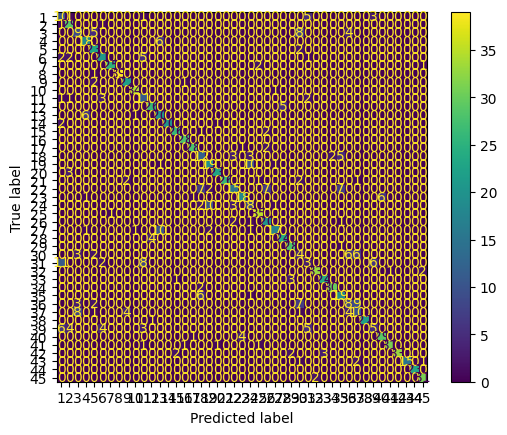

In [23]:
display_confusion_matrix(cm, labels)

In [24]:
acc

0.7412587412587412

#### 75% accuracy prediction of store label - not terrible
let's see the results with the "prev" and "diff" columns, **including weekly_sales_diff** -  more data, even though partially reduntant

In [26]:
df_week_prev_diff_store = df_eng[['store', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month', 'prev_weekly_sales', 'prev_temperature',
       'prev_fuel_price', 'prev_cpi', 'prev_unemployment', 'weekly_sales_diff',
       'temperature_diff', 'fuel_price_diff', 'cpi_diff', 'unemployment_diff',
       'prev_holiday_flag', 'holiday_flag_diff', 'prev_month',
       'prev_week_number', 'prev_week_of_month']]

In [36]:
acc, f1, cm, labels, model, preds, X_valid, y_valid, train_pipeline, dataset = preprocess_and_train_classification(model = svc_model,
                                                                                                          dataset = df_week_prev_diff_store,
                                                                                                          target_col = 'store')

In [29]:
acc

0.6402486402486403

Unfortunately - a reduction in accuracy. Maybe a change of models could help?

#### Classification model and dataset exploration
Let's explore the extreme gradient boosting method that worked so well for the regression task as well as other methods more suited to classification tasks such as K Neighbor classification.

In [32]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier

define the datasets

In [40]:
# the base dataframe information
df_noeng_store = df_eng[['store', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment']]

# with additional week information
df_week_store = df_eng[['store', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month']]

# with additional information about week and month AND data about the previous week
df_week_prev_store = df_eng[['store', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month', 'prev_weekly_sales', 'prev_temperature',
       'prev_fuel_price', 'prev_cpi', 'prev_unemployment', 'prev_month',
       'prev_week_number', 'prev_week_of_month']]

# and 'diff'
df_week_prev_diff_store = df_eng[['store', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month', 'prev_weekly_sales', 'prev_temperature',
       'prev_fuel_price', 'prev_cpi', 'prev_unemployment', 'weekly_sales_diff',
       'temperature_diff', 'fuel_price_diff', 'cpi_diff', 'unemployment_diff',
       'prev_holiday_flag', 'holiday_flag_diff', 'prev_month',
       'prev_week_number', 'prev_week_of_month']]

# only data unique to region / store
df_unique_store = df_eng[['store', 'weekly_sales', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'prev_weekly_sales', 'prev_temperature',
       'prev_fuel_price', 'prev_cpi', 'prev_unemployment', 'weekly_sales_diff',
       'temperature_diff', 'fuel_price_diff', 'cpi_diff', 'unemployment_diff']]

datasets = [df_noeng_store, df_week_store, df_week_prev_store, df_week_prev_diff_store, df_unique_store]
dataset_names = ['df_noeng_store', 'df_week_store', 'df_week_prev_store',
                 'df_week_prev_diff_store', 'df_unique_store']

#### no hyperparameter tuning so far

In [65]:
c_random_forest_model = RandomForestClassifier()
svc_model = SVC()
knc_model = KNeighborsClassifier()
c_tree_model = DecisionTreeClassifier()
# xgb_c_model = XGBClassifier()
# models = [c_random_forest_model, svc_model, knc_model, c_tree_model, xgb_c_model]
# model_names = ['random_forest', 'svc', 'kneighbors', 'tree', 'xgb']
models = [c_random_forest_model, svc_model, knc_model, c_tree_model]
model_names = ['random_forest', 'svc', 'kneighbors', 'tree']

#### Store number to label / category

In [49]:
from sklearn import preprocessing
from sklearn import utils

In [50]:
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(df_eng['store'])

In [51]:
encoded

array([ 0,  0,  0, ..., 44, 44, 44], dtype=int64)

In [52]:
print(utils.multiclass.type_of_target(encoded))

multiclass


#### Warning - comment out expensive operation for the sake of rerunning

In [66]:
results_df = pd.DataFrame()
acc_best = 0
best_model = None
best_dataset = None
for d_index, dataset in enumerate(datasets):
    for m_index, model in enumerate(models):
        for to_scale in [True, False]:
            model_name = f'{model_names[m_index]}_{dataset_names[d_index]}'
            if to_scale:
                model_name += '_scaled'
            else:
                model_name += '_not_scaled'
    
            # reset the models
            c_random_forest_model = RandomForestClassifier()
            svc_model = SVC()
            knc_model = KNeighborsClassifier()
            c_tree_model = DecisionTreeClassifier()
            xgb_c_model = XGBClassifier()
            
            acc, f1, cm, labels, model, preds, X_valid, y_valid, result_model, used_dataset = preprocess_and_train_classification(
                                            model = model,
                                            dataset = dataset,
                                            target_col = 'store',
                                            standard_scale=to_scale,
                                            model_name = model_name
                                           )
            
            results_df = model_results_to_dataframe(acc, f1, cm, model_name, results_df)
    
            if acc > acc_best:
                best_model = result_model
                best_dataset = used_dataset

model random_forest_df_noeng_store_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model random_forest_df_noeng_store_scaled trained, acc: 0.9728049728049728
model random_forest_df_noeng_store_not_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model random_forest_df_noeng_store_not_scaled trained, acc: 0.9634809634809635
model svc_df_noeng_store_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model svc_df_noeng_store_scaled trained, acc: 0.7824397824397824
model svc_df_noeng_store_not_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model svc_df_noeng_store_not_scaled trained, acc: 0.20590520590520592
model kneighbors_df_noeng_store_scaled started training
model kneighbors_df_noeng_store_scaled trained, acc: 0.8057498057498057
model kneighbors_df_noeng_store_not_scaled started training
model kneighbors_df_noeng_store_not_scaled trained, acc: 0.19658119658119658
model tree_df_noeng_store_scaled started training
model tree_df_noeng_store_scaled trained, acc: 0.9526029526029526
model tree_df_noeng_store_not_scaled started training
model tree_df_noeng_store_not_scaled trained, acc: 0.9471639471639471
model random_forest_df_week_store_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model random_forest_df_week_store_scaled trained, acc: 0.9696969696969697
model random_forest_df_week_store_not_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model random_forest_df_week_store_not_scaled trained, acc: 0.9751359751359752
model svc_df_week_store_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model svc_df_week_store_scaled trained, acc: 0.7606837606837606
model svc_df_week_store_not_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model svc_df_week_store_not_scaled trained, acc: 0.16783216783216784
model kneighbors_df_week_store_scaled started training
model kneighbors_df_week_store_scaled trained, acc: 0.5151515151515151
model kneighbors_df_week_store_not_scaled started training
model kneighbors_df_week_store_not_scaled trained, acc: 0.21833721833721834
model tree_df_week_store_scaled started training
model tree_df_week_store_scaled trained, acc: 0.9588189588189588
model tree_df_week_store_not_scaled started training
model tree_df_week_store_not_scaled trained, acc: 0.958041958041958
model random_forest_df_week_prev_store_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model random_forest_df_week_prev_store_scaled trained, acc: 0.9797979797979798
model random_forest_df_week_prev_store_not_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model random_forest_df_week_prev_store_not_scaled trained, acc: 0.986013986013986
model svc_df_week_prev_store_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model svc_df_week_prev_store_scaled trained, acc: 0.7653457653457654
model svc_df_week_prev_store_not_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model svc_df_week_prev_store_not_scaled trained, acc: 0.2097902097902098
model kneighbors_df_week_prev_store_scaled started training
model kneighbors_df_week_prev_store_scaled trained, acc: 0.4677544677544678
model kneighbors_df_week_prev_store_not_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


model kneighbors_df_week_prev_store_not_scaled trained, acc: 0.24087024087024086
model tree_df_week_prev_store_scaled started training
model tree_df_week_prev_store_scaled trained, acc: 0.9308469308469308
model tree_df_week_prev_store_not_scaled started training
model tree_df_week_prev_store_not_scaled trained, acc: 0.9324009324009324
model random_forest_df_week_prev_diff_store_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model random_forest_df_week_prev_diff_store_scaled trained, acc: 0.9805749805749806
model random_forest_df_week_prev_diff_store_not_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model random_forest_df_week_prev_diff_store_not_scaled trained, acc: 0.9790209790209791
model svc_df_week_prev_diff_store_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model svc_df_week_prev_diff_store_scaled trained, acc: 0.6534576534576535
model svc_df_week_prev_diff_store_not_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model svc_df_week_prev_diff_store_not_scaled trained, acc: 0.21445221445221446
model kneighbors_df_week_prev_diff_store_scaled started training
model kneighbors_df_week_prev_diff_store_scaled trained, acc: 0.2463092463092463
model kneighbors_df_week_prev_diff_store_not_scaled started training
model kneighbors_df_week_prev_diff_store_not_scaled trained, acc: 0.23465423465423466
model tree_df_week_prev_diff_store_scaled started training
model tree_df_week_prev_diff_store_scaled trained, acc: 0.9502719502719502
model tree_df_week_prev_diff_store_not_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


model tree_df_week_prev_diff_store_not_scaled trained, acc: 0.9463869463869464
model random_forest_df_unique_store_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model random_forest_df_unique_store_scaled trained, acc: 0.9790209790209791
model random_forest_df_unique_store_not_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model random_forest_df_unique_store_not_scaled trained, acc: 0.9766899766899767
model svc_df_unique_store_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model svc_df_unique_store_scaled trained, acc: 0.7536907536907537
model svc_df_unique_store_not_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model svc_df_unique_store_not_scaled trained, acc: 0.17016317016317017
model kneighbors_df_unique_store_scaled started training
model kneighbors_df_unique_store_scaled trained, acc: 0.49572649572649574
model kneighbors_df_unique_store_not_scaled started training
model kneighbors_df_unique_store_not_scaled trained, acc: 0.24397824397824397
model tree_df_unique_store_scaled started training


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


model tree_df_unique_store_scaled trained, acc: 0.9316239316239316
model tree_df_unique_store_not_scaled started training
model tree_df_unique_store_not_scaled trained, acc: 0.9456099456099456


#### Note: For some reason, XGB models fail on the training step
Somehow the labels get mismatched from store numbers 1-45 to 0-44 - but only for XGB models

In [67]:
results_df

,model,acc,cm,f1
0,random_forest_df_noeng_store_scaled,0.972805,"[[24, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.9230769230769231, 0.9315068493150684, 0.972..."
1,random_forest_df_noeng_store_not_scaled,0.963481,"[[29, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.8923076923076924, 0.9538461538461539, 0.941..."
2,svc_df_noeng_store_scaled,0.782440,"[[16, 3, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0...","[0.6153846153846154, 0.7547169811320755, 0.666..."
3,svc_df_noeng_store_not_scaled,0.205905,"[[1, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 1, 0, 0...","[0.05263157894736842, 0.2631578947368421, 0.0,..."
4,kneighbors_df_noeng_store_scaled,0.805750,"[[21, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0...","[0.5526315789473685, 0.7536231884057971, 0.718..."
5,kneighbors_df_noeng_store_not_scaled,0.196581,"[[11, 1, 0, 1, 0, 3, 0, 0, 0, 1, 2, 0, 0, 1, 0...","[0.19469026548672566, 0.19047619047619047, 0.3..."
6,tree_df_noeng_store_scaled,0.952603,"[[24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0...","[0.8135593220338984, 0.9032258064516129, 0.950..."
7,tree_df_noeng_store_not_scaled,0.947164,"[[15, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.8571428571428571, 0.8695652173913043, 0.830..."
8,random_forest_df_week_store_scaled,0.969697,"[[23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.9387755102040817, 0.9333333333333333, 1.0, ..."
9,random_forest_df_week_store_not_scaled,0.975136,"[[23, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.92, 0.9387755102040817, 0.9615384615384616,..."


In [68]:
results_df.to_csv('../store_classification_results.csv')

### Store classification results

In [71]:
results_df.sort_values(by=['acc'], ascending=False).head()

,model,acc,cm,f1
17,random_forest_df_week_prev_store_not_scaled,0.986014,"[[27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.9818181818181818, 0.9818181818181818, 1.0, ..."
24,random_forest_df_week_prev_diff_store_scaled,0.980575,"[[26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.896551724137931, 0.9846153846153847, 0.9841..."
16,random_forest_df_week_prev_store_scaled,0.979798,"[[26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.9122807017543859, 0.9411764705882353, 0.966..."
32,random_forest_df_unique_store_scaled,0.979021,"[[26, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.9285714285714286, 0.9433962264150944, 0.981..."
25,random_forest_df_week_prev_diff_store_not_scaled,0.979021,"[[21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0.9130434782608695, 0.967741935483871, 1.0, 0..."


## Important note - dataframe with all engineered features saved to file 'walmart_sales_engineered.csv'

In [ ]:
# df.to_csv('../datasets/walmart_sales_engineered.csv')